# Import Cell

In [8]:
import os
import pandas as pd
import numpy as np
import xlrd
import csv
import sys
import win32com.client
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statistics
import math
import matplotlib as mp
from matplotlib import pylab
from scipy import stats
from scipy.stats.stats import pearsonr
from itertools import groupby
from more_itertools import unique_everseen
import seaborn
%matplotlib inline

# Generate Subject and File Lists

In [9]:
root = "S:\\Killgore_SCAN\\UA_SCAN_Shared\\PREEMPT\\"
dumplist = []
for p,s,f in os.walk(root):
    for n in f:
        dumplist.append(os.path.join(p,n))

xlApp = win32com.client.Dispatch('Excel.Application')
masterobject = xlApp.Workbooks.Open(root+"Tracking_Storage_Scheduling_Logs\\PREEMPT_Subject_Masterlist.xlsx", False, True, None, Password='').Worksheets(1)
masterlist = pd.DataFrame(list(masterobject.Range(masterobject.Cells(1,1),masterobject.Cells(masterobject.UsedRange.Rows.Count,19)).Value))
masterlist.columns = masterlist.iloc[0]
masterlist.reindex(masterlist.index.drop(0))
v2subslist = list(masterlist[masterlist.Status == 'V2 Complete']['Record ID'].astype(int))
v2subslist.sort()

cortdf = pd.read_excel(open(root+'Analyses\\Cortisol\\Cortisol_Analysis.xlsx',"rb"), index_col=False)
cortdf['Log Mean (µg/dL)'] = [math.log(y,10) for y in cortdf['Mean (µg/dL)']]
trierdf = cortdf.loc[(cortdf['General Time'] == 8) | (cortdf['General Time'] == 9)]
triersubloopdf = cortdf.loc[(cortdf['General Time'] == 8)]
cortsubslist = list(triersubloopdf['Record ID'].astype(int))
cortsubslist.sort()

fileslist = [x for x in dumplist if "UA_SCAN_Shared\\PREEMPT\\Data\\PREEMPT1_" in x]
fileslist[:] = [x for x in fileslist if any("PREEMPT1_%04d" % y in x for y in cortsubslist)]

markovlist = [x for x in fileslist if "aliens_task.csv" in x]
ospanalllist = [x for x in fileslist if "ospan" in x]
ospanlist = [x for x in ospanalllist if not "math" in x]
msceitlist = [x for x in fileslist if (("msceit" in x) or ("MSCEIT" in x))]
eqilist = [x for x in fileslist if (("eqi2" in x) or ("EQi" in x) or ("EQI" in x) or ("eqi" in x))]
neolist = [x for x in fileslist if (("neo3" in x) and ("copy1" in x))]

# Build Data Vectors (Dependent on File Lists)

In [11]:
msceittotallist = []
msceitexparealist = []
msceitstratarealist = []
msceitpercbranchlist = []
msceitusingbranchlist = []
msceitunderbranchlist = []
msceitmanagebranchlist = []
eqitotallist = []; eqisplist = []; eqisrlist = []; eqisalist = []; eqieslist = []; eqiselist = []; eqieelist = []; eqiaslist = []; eqiinlist = []; eqiislist = []; eqiirlist = []; eqiemlist = []; eqirelist = []; eqidmlist = []; eqipslist = []; eqirtlist = []; eqiiclist = []; eqiiclist = []; eqismlist = []; eqifllist = []; eqistlist = []; eqioplist = []; eqihalist = []
pretrierlist8 = []
posttrierlist9 = []
diftrierlist = []
moodlist = []; moodcortlist = []; agelist = []; agecortlist = []; genderlist = []; gendercortlist = []; testorderlist = []; testordercortlist = []
scorelist = []
cortsampleslist = []

for x in v2subslist:
    moodlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Mood Condition'][0])
    agelist.append(masterlist[masterlist['Record ID']==x].reset_index()['Age'][0])
    genderlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Gender'][0])
    testorderlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Test Order'][0])
for x in cortsubslist:
    moodcortlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Mood Condition'][0])
    agecortlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Age'][0])
    gendercortlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Gender'][0])
    testordercortlist.append(masterlist[masterlist['Record ID']==x].reset_index()['Test Order'][0])
for x in ospanlist:
    scorelist.append(pd.read_csv(x)['runningcorrect'].iloc[-1])
for x in msceitlist:
    msceittotallist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_TOT'][0])
    msceitexparealist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_EXP'][0])
    msceitstratarealist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_REA'][0])
    msceitpercbranchlist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_B1'][0])
    msceitusingbranchlist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_B2'][0])
    msceitunderbranchlist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_B3'][0])
    msceitmanagebranchlist.append(pd.read_excel(open(x,"rb"),sheet_name='MSCEIT_Demographic_and_Scores')['SS_B4'][0])
for x in eqilist:
    eqitotallist.append(pd.read_excel(x,sheet_name='EQ_i_2.0_Scores')['TOT_T'][0])
    eqisplist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['SP_T'][0])
    eqisrlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['SR_T'][0])
    eqisalist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['SA_T'][0])
    eqieslist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['ES_T'][0])
    eqiselist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['SE_T'][0])
    eqieelist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['EE_T'][0])
    eqiaslist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['AS_T'][0])
    eqiinlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['IN_T'][0])
    eqiislist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['IS_T'][0])
    eqiirlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['IR_T'][0])
    eqiemlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['EM_T'][0])
    eqirelist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['RE_T'][0])
    eqidmlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['DM_T'][0])
    eqipslist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['PS_T'][0])
    eqirtlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['RT_T'][0])
    eqiiclist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['IC_T'][0])
    eqismlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['SM_T'][0])
    eqifllist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['FL_T'][0])
    eqistlist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['ST_T'][0])
    eqioplist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['OP_T'][0])
    eqihalist.append(pd.read_excel(open(x,"rb"),sheet_name='EQ_i_2.0_Scores')['HA_T'][0])
for x in cortsubslist:
    try:
        pretrierlist8.append(trierdf.loc[(trierdf['Record ID'] == int(x)) & (trierdf['General Time'] == 8), 'Mean (µg/dL)'].iloc[0])
        posttrierlist9.append(trierdf.loc[(trierdf['Record ID'] == int(x)) & (trierdf['General Time'] == 9), 'Mean (µg/dL)'].iloc[0])
    except:
        pass
pretrierlist8 = [math.log(y,10) for y in pretrierlist8]
posttrierlist9 = [math.log(y,10) for y in posttrierlist9]
diftrierlist = [i-j for i,j in zip(posttrierlist9,pretrierlist8)]
diftrierlistz = stats.mstats.zscore(diftrierlist)
cortsampleslist = []
for x in list(cortsubslist):
    subrow = cortdf[cortdf['Record ID'] == x].reset_index()
    if len(subrow.index) > 0:
        temp = []
        for x in range(1,12):
            try:
                temp.append(subrow[subrow['General Time'] == x].reset_index()['Mean (µg/dL)'][0])
            except:
                temp.append(None)
        cortsampleslist.append(temp)

TypeError: expected str, bytes or os.PathLike object, not NoneType

# Build Markov Dataframe (Dependent on File Lists)

In [6]:
for i, x in enumerate(markovlist):
    name = os.path.basename(x)[9:13]
    if i == 0:
        df = pd.read_csv(x, delimiter=',', index_col=False)
        df = df.iloc[9:]
        df.insert(0, 'SubjectID', name)
    elif i > 0:
        tempdf = pd.read_csv(x, delimiter=',', index_col=False)
        tempdf = tempdf.iloc[9:]
        tempdf.insert(0, 'SubjectID', name)
        df = df.append(tempdf, ignore_index=True)

level1list = []
level2list = []
        
df = df.drop(df[df.choice1 == 0].index)
df = df.drop(df[df.choice2 == 0].index)

table = pd.DataFrame(
        {'subjID': df.SubjectID,
         'reward': df.money
        })

for x in list(df.choice1):
    level1list.append('stimulus %s' % x)
    
table['level1_choice'] = level1list
    
this = 10*df.choice1 + df.choice2

for x in this:
    if x == 11:
        level2list.append('stimulus 3')
    if x == 12:
        level2list.append('stimulus 4')
    if x == 21:
        level2list.append('stimulus 5')
    if x == 22:
        level2list.append('stimulus 6')
            
table['level2_choice'] = level2list

df.to_csv("markov_dataset.csv", sep=',', index=False)
table.to_csv("markov_dataset.txt", sep='\t', index=False)

# Gather VAS Responses (Dependent on File Lists)

In [6]:
df = pd.read_csv('C:\\Users\\localadmin\\Python Scripts\\vasday2_dataset.csv', delimiter=',', index_col=False)
df['record_id'] = df['record_id'].str[9:].astype(int)
vasalertlist = []; vassadlist = []; vastenselist = []; vaseffortlist = []; vashappylist = []; vaswearylist = []; vascalmlist = []; vassleepylist = []; vasglobalvigorlist = []; vasglobalaffectlist = []
vasalertcortlist = []; vassadcortlist = []; vastensecortlist = []; vaseffortcortlist = []; vashappycortlist = []; vaswearycortlist = []; vascalmcortlist = []; vassleepycortlist = []; vasglobalvigorcortlist = []; vasglobalaffectcortlist = []
vasalertmeanlist = []; vassadmeanlist = []; vastensemeanlist = []; vaseffortmeanlist = []; vaseffortmeanlist = []; vashappymeanlist = []; vaswearymeanlist = []; vascalmmeanlist = []; vassleepymeanlist = []; vasglobalvigormeanlist = []; vasglobalaffectmeanlist = []
vasalertcortmeanlist = []; vassadcortmeanlist = []; vastensecortmeanlist = []; vaseffortcortmeanlist = []; vaseffortcortmeanlist = []; vashappycortmeanlist = []; vaswearycortmeanlist = []; vascalmcortmeanlist = []; vassleepycortmeanlist = []; vasglobalvigorcortmeanlist = []; vasglobalaffectcortmeanlist = []
for x in v2subslist:
    subrow = df[df['record_id'] == x].reset_index()
    if len(subrow.index) > 0:
        vasalertlist.append([subrow['vas_alert_1'][0],subrow['vas_alert_2'][0],subrow['vas_mood_boost_alert'][0],subrow['vas_mood_boost_alert_2'][0],subrow['vas_mood_boost_alert_3'][0],subrow['vas_mood_boost_alert_4'][0],subrow['vas_mood_boost_alert_5'][0],subrow['vas_mood_boost_alert_6'][0],subrow['vas_mood_boost_alert_7'][0],subrow['vas_alert_3'][0]])
        vassadlist.append([subrow['vas_sad_1'][0],subrow['vas_sad_2'][0],subrow['vas_mood_boost_sad'][0],subrow['vas_mood_boost_sad_2'][0],subrow['vas_mood_boost_sad_3'][0],subrow['vas_mood_boost_sad_4'][0],subrow['vas_mood_boost_sad_5'][0],subrow['vas_mood_boost_sad_6'][0],subrow['vas_mood_boost_sad_7'][0],subrow['vas_sad_3'][0]])
        vastenselist.append([subrow['vas_tense_1'][0],subrow['vas_tense_2'][0],subrow['vas_mood_boost_tense'][0],subrow['vas_mood_boost_tense_2'][0],subrow['vas_mood_boost_tense_3'][0],subrow['vas_mood_boost_tense_4'][0],subrow['vas_mood_boost_tense_5'][0],subrow['vas_mood_boost_tense_6'][0],subrow['vas_mood_boost_tense_7'][0],subrow['vas_tense_3'][0]])
        vaseffortlist.append([subrow['vas_effort_1'][0],subrow['vas_effort_2'][0],subrow['vas_mood_boost_effort'][0],subrow['vas_mood_boost_effort_2'][0],subrow['vas_mood_boost_effort_3'][0],subrow['vas_mood_boost_effort_4'][0],subrow['vas_mood_boost_effort_5'][0],subrow['vas_mood_boost_effort_6'][0],subrow['vas_mood_boost_effort_7'][0],subrow['vas_effort_3'][0]])
        vashappylist.append([subrow['vas_happy_1'][0],subrow['vas_happy_2'][0],subrow['vas_mood_boost_happy'][0],subrow['vas_mood_boost_happy_2'][0],subrow['vas_mood_boost_happy_3'][0],subrow['vas_mood_boost_happy_4'][0],subrow['vas_mood_boost_happy_5'][0],subrow['vas_mood_boost_happy_6'][0],subrow['vas_mood_boost_happy_7'][0],subrow['vas_happy_3'][0]])
        vaswearylist.append([subrow['vas_weary_1'][0],subrow['vas_weary_2'][0],subrow['vas_mood_boost_weary'][0],subrow['vas_mood_boost_weary_2'][0],subrow['vas_mood_boost_weary_3'][0],subrow['vas_mood_boost_weary_4'][0],subrow['vas_mood_boost_weary_5'][0],subrow['vas_mood_boost_weary_6'][0],subrow['vas_mood_boost_weary_7'][0],subrow['vas_weary_3'][0]])
        vascalmlist.append([subrow['vas_calm_1'][0],subrow['vas_calm_2'][0],subrow['vas_mood_boost_calm'][0],subrow['vas_mood_boost_calm_2'][0],subrow['vas_mood_boost_calm_3'][0],subrow['vas_mood_boost_calm_4'][0],subrow['vas_mood_boost_calm_5'][0],subrow['vas_mood_boost_calm_6'][0],subrow['vas_mood_boost_calm_7'][0],subrow['vas_calm_3'][0]])
        vassleepylist.append([subrow['vas_sleepy_1'][0],subrow['vas_sleepy_2'][0],subrow['vas_mood_boost_sleepy'][0],subrow['vas_mood_boost_sleepy_2'][0],subrow['vas_mood_boost_sleepy_3'][0],subrow['vas_mood_boost_sleepy_4'][0],subrow['vas_mood_boost_sleepy_5'][0],subrow['vas_mood_boost_sleepy_6'][0],subrow['vas_mood_boost_sleepy_7'][0],subrow['vas_sleepy_3'][0]])
        vasglobalvigorlist.append([subrow['vas_global_vigor_1'][0],subrow['vas_global_vigor_2'][0],subrow['vas_mood_boost_global_vigor'][0],subrow['vas_mood_boost_global_vigor_2'][0],subrow['vas_mood_boost_global_vigor_3'][0],subrow['vas_mood_boost_global_vigor_4'][0],subrow['vas_mood_boost_global_vigor_5'][0],subrow['vas_mood_boost_global_vigor_6'][0],subrow['vas_mood_boost_global_vigor_7'][0],subrow['vas_global_vigor_3'][0]])
        vasglobalaffectlist.append([subrow['vas_global_affect_1'][0],subrow['vas_global_affect_2'][0],subrow['vas_mood_boost_global_affect'][0],subrow['vas_mood_boost_global_affect_2'][0],subrow['vas_mood_boost_global_affect_3'][0],subrow['vas_mood_boost_global_affect_4'][0],subrow['vas_mood_boost_global_affect_5'][0],subrow['vas_mood_boost_global_affect_6'][0],subrow['vas_mood_boost_global_affect_7'][0],subrow['vas_global_affect_3'][0]])
for x in vasalertlist:
    vasalertmeanlist.append(statistics.mean(x))
for x in vassadlist:
    vassadmeanlist.append(statistics.mean(x))
for x in vastenselist: 
    vastensemeanlist.append(statistics.mean(x))
for x in vaseffortlist:
    vaseffortmeanlist.append(statistics.mean(x))
for x in vashappylist:
    vashappymeanlist.append(statistics.mean(x))
for x in vaswearylist:
    vaswearymeanlist.append(statistics.mean(x))
for x in vascalmlist:
    vascalmmeanlist.append(statistics.mean(x))
for x in vassleepylist:
    vassleepymeanlist.append(statistics.mean(x))
for x in vasglobalvigorlist:
    vasglobalvigormeanlist.append(statistics.mean(x))
for x in vasglobalaffectlist:
    vasglobalaffectmeanlist.append(statistics.mean(x))
for x in cortsubslist:
    subrow = df[df['record_id'] == x].reset_index()
    if len(subrow.index) > 0:
        vasalertcortlist.append([subrow['vas_alert_1'][0],subrow['vas_alert_2'][0],subrow['vas_mood_boost_alert'][0],subrow['vas_mood_boost_alert_2'][0],subrow['vas_mood_boost_alert_3'][0],subrow['vas_mood_boost_alert_4'][0],subrow['vas_mood_boost_alert_5'][0],subrow['vas_mood_boost_alert_6'][0],subrow['vas_mood_boost_alert_7'][0],subrow['vas_alert_3'][0]])
        vassadcortlist.append([subrow['vas_sad_1'][0],subrow['vas_sad_2'][0],subrow['vas_mood_boost_sad'][0],subrow['vas_mood_boost_sad_2'][0],subrow['vas_mood_boost_sad_3'][0],subrow['vas_mood_boost_sad_4'][0],subrow['vas_mood_boost_sad_5'][0],subrow['vas_mood_boost_sad_6'][0],subrow['vas_mood_boost_sad_7'][0],subrow['vas_sad_3'][0]])
        vastensecortlist.append([subrow['vas_tense_1'][0],subrow['vas_tense_2'][0],subrow['vas_mood_boost_tense'][0],subrow['vas_mood_boost_tense_2'][0],subrow['vas_mood_boost_tense_3'][0],subrow['vas_mood_boost_tense_4'][0],subrow['vas_mood_boost_tense_5'][0],subrow['vas_mood_boost_tense_6'][0],subrow['vas_mood_boost_tense_7'][0],subrow['vas_tense_3'][0]])
        vaseffortcortlist.append([subrow['vas_effort_1'][0],subrow['vas_effort_2'][0],subrow['vas_mood_boost_effort'][0],subrow['vas_mood_boost_effort_2'][0],subrow['vas_mood_boost_effort_3'][0],subrow['vas_mood_boost_effort_4'][0],subrow['vas_mood_boost_effort_5'][0],subrow['vas_mood_boost_effort_6'][0],subrow['vas_mood_boost_effort_7'][0],subrow['vas_effort_3'][0]])
        vashappycortlist.append([subrow['vas_happy_1'][0],subrow['vas_happy_2'][0],subrow['vas_mood_boost_happy'][0],subrow['vas_mood_boost_happy_2'][0],subrow['vas_mood_boost_happy_3'][0],subrow['vas_mood_boost_happy_4'][0],subrow['vas_mood_boost_happy_5'][0],subrow['vas_mood_boost_happy_6'][0],subrow['vas_mood_boost_happy_7'][0],subrow['vas_happy_3'][0]])
        vaswearycortlist.append([subrow['vas_weary_1'][0],subrow['vas_weary_2'][0],subrow['vas_mood_boost_weary'][0],subrow['vas_mood_boost_weary_2'][0],subrow['vas_mood_boost_weary_3'][0],subrow['vas_mood_boost_weary_4'][0],subrow['vas_mood_boost_weary_5'][0],subrow['vas_mood_boost_weary_6'][0],subrow['vas_mood_boost_weary_7'][0],subrow['vas_weary_3'][0]])
        vascalmcortlist.append([subrow['vas_calm_1'][0],subrow['vas_calm_2'][0],subrow['vas_mood_boost_calm'][0],subrow['vas_mood_boost_calm_2'][0],subrow['vas_mood_boost_calm_3'][0],subrow['vas_mood_boost_calm_4'][0],subrow['vas_mood_boost_calm_5'][0],subrow['vas_mood_boost_calm_6'][0],subrow['vas_mood_boost_calm_7'][0],subrow['vas_calm_3'][0]])
        vassleepycortlist.append([subrow['vas_sleepy_1'][0],subrow['vas_sleepy_2'][0],subrow['vas_mood_boost_sleepy'][0],subrow['vas_mood_boost_sleepy_2'][0],subrow['vas_mood_boost_sleepy_3'][0],subrow['vas_mood_boost_sleepy_4'][0],subrow['vas_mood_boost_sleepy_5'][0],subrow['vas_mood_boost_sleepy_6'][0],subrow['vas_mood_boost_sleepy_7'][0],subrow['vas_sleepy_3'][0]])
        vasglobalvigorcortlist.append([subrow['vas_global_vigor_1'][0],subrow['vas_global_vigor_2'][0],subrow['vas_mood_boost_global_vigor'][0],subrow['vas_mood_boost_global_vigor_2'][0],subrow['vas_mood_boost_global_vigor_3'][0],subrow['vas_mood_boost_global_vigor_4'][0],subrow['vas_mood_boost_global_vigor_5'][0],subrow['vas_mood_boost_global_vigor_6'][0],subrow['vas_mood_boost_global_vigor_7'][0],subrow['vas_global_vigor_3'][0]])
        vasglobalaffectcortlist.append([subrow['vas_global_affect_1'][0],subrow['vas_global_affect_2'][0],subrow['vas_mood_boost_global_affect'][0],subrow['vas_mood_boost_global_affect_2'][0],subrow['vas_mood_boost_global_affect_3'][0],subrow['vas_mood_boost_global_affect_4'][0],subrow['vas_mood_boost_global_affect_5'][0],subrow['vas_mood_boost_global_affect_6'][0],subrow['vas_mood_boost_global_affect_7'][0],subrow['vas_global_affect_3'][0]])
for x in vasalertcortlist:
    vasalertcortmeanlist.append(statistics.mean(x))
for x in vassadcortlist:
    vassadcortmeanlist.append(statistics.mean(x))
for x in vastensecortlist: 
    vastensecortmeanlist.append(statistics.mean(x))
for x in vaseffortcortlist:
    vaseffortcortmeanlist.append(statistics.mean(x))
for x in vashappycortlist:
    vashappycortmeanlist.append(statistics.mean(x))
for x in vaswearycortlist:
    vaswearycortmeanlist.append(statistics.mean(x))
for x in vascalmcortlist:
    vascalmcortmeanlist.append(statistics.mean(x))
for x in vassleepycortlist:
    vassleepycortmeanlist.append(statistics.mean(x))
for x in vasglobalvigorcortlist:
    vasglobalvigorcortmeanlist.append(statistics.mean(x))
for x in vasglobalaffectcortlist:
    vasglobalaffectcortmeanlist.append(statistics.mean(x))

# Build Vectors for Markov Computational Model Parameters

In [27]:
df = pd.read_csv('C:\\Users\\localadmin\\Python Scripts\\compmodeloutput.csv', delimiter=',', index_col=False)
modela1cortlist = []; modela2cortlist = []; modelb1cortlist = []; modelb2cortlist = []; modelpicortlist = []; modelwcortlist = []; modellambdacortlist = []; modelloglikcortlist = []
for i, x in enumerate(cortsubslist):
    modela1cortlist.append(df.loc[df['Unnamed: 0'] == 'a1[%s]' % str(i+1), 'mean'].iloc[0])
    modela2cortlist.append(df.loc[df['Unnamed: 0'] == 'a2[%s]' % str(i+1), 'mean'].iloc[0])
    modelb1cortlist.append(df.loc[df['Unnamed: 0'] == 'beta1[%s]' % str(i+1), 'mean'].iloc[0])
    modelb2cortlist.append(df.loc[df['Unnamed: 0'] == 'beta2[%s]' % str(i+1), 'mean'].iloc[0])
    modelpicortlist.append(df.loc[df['Unnamed: 0'] == 'pi[%s]' % str(i+1), 'mean'].iloc[0])
    modelwcortlist.append(df.loc[df['Unnamed: 0'] == 'w[%s]' % str(i+1), 'mean'].iloc[0])
    modellambdacortlist.append(df.loc[df['Unnamed: 0'] == 'lambda[%s]' % str(i+1), 'mean'].iloc[0])
    modelloglikcortlist.append(df.loc[df['Unnamed: 0'] == 'log_lik[%s]' % str(i+1), 'mean'].iloc[0])
modelb1basedcortlist = [i*j for i,j in zip(modelb1cortlist,modelwcortlist)]
modelb2basedcortlist = [i*j for i,j in zip(modelb2cortlist,modelwcortlist)]
modelb1freecortlist = [i*(1-j) for i,j in zip(modelb1cortlist,modelwcortlist)]
modelb2freecortlist = [i*(1-j) for i,j in zip(modelb2cortlist,modelwcortlist)]

# Build Vectors for Markov Regression Model Parameters

In [4]:
df = pd.read_csv('C:\\Users\\localadmin\\Python Scripts\\markov_dataset.csv', delimiter=',', index_col=False)
modelfreebetaslist = []; modelbasedbetaslist = []
modelfreebetascortlist = []; modelbasedbetascortlist = []

for x in cortsubslist:
    model = smf.mixedlm('stay ~ prevmoney + common + prevmoney * common', df[pd.to_numeric(df.SubjectID) == x], groups=df[pd.to_numeric(df.SubjectID) == x]['SubjectID']).fit()
    modelfreebetascortlist.append(model.params[1])
    modelbasedbetascortlist.append(model.params[3])

c:\users\localadmin\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\users\localadmin\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\users\localadmin\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Generate Scatter Plots (No Grouping)

r = 0.07288159677087427, p = 0.7234746574201003


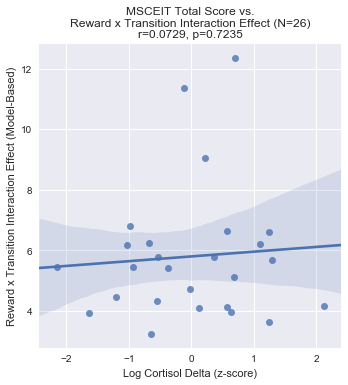

In [44]:
#Edit These
SAVE = False
var1 = diftrierlistz
var2 = modelb1cortlist
var1label = "Log Cortisol Delta (z-score)"
var2label = "Reward x Transition Interaction Effect (Model-Based)"
title = "MSCEIT Total Score vs.\nReward x Transition Interaction Effect (N=%s)" % len(var1)
savename = "Analyses\\Markov\\MSCEITTotal-ModelBased.pdf"

#--------------------------------------------
table = pd.DataFrame(
    {var1label: var1,
    var2label: var2
    })
for x in table.columns:
    table = table[np.isfinite(table[x])]

lm = seaborn.lmplot(x=var1label, y=var2label, palette=('r'), data=table, legend_out=False)
ax = mp.pyplot.gca()
ax.set_title("%s\nr=%.4f, p=%.4f" % (title,pearsonr(table[var1label],table[var2label])[0],pearsonr(table[var1label],table[var2label])[1]))
print("r = %s, p = %s" % pearsonr(table[var1label],table[var2label]))
if SAVE == True:
    lm.savefig(root+savename, bbox_inches='tight')

# Generate Bar Graphs (Group Averages)

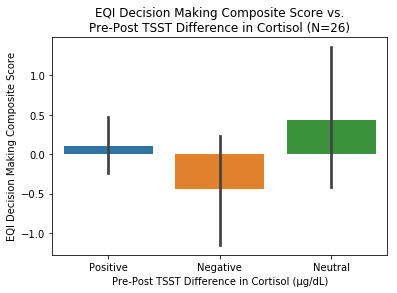

In [7]:
#Edit These
SAVE = False
var = diftrierlistz
groupvar = moodcortlist
varlabel = "EQI Decision Making Composite Score"
grouplabel = "Pre-Post TSST Difference in Cortisol (µg/dL)"
title = "EQI Decision Making Composite Score vs.\nPre-Post TSST Difference in Cortisol (N=%s)" % len(var)
savename = "Analyses\\EQI\\EQIDecisionMaking-PrePostDifTSSTCortisol.pdf"

table = pd.DataFrame(
    {varlabel: var,
    grouplabel: groupvar
    })
table = table[np.isfinite(table[varlabel])]

bp = seaborn.barplot(x=grouplabel, y=varlabel, data=table)
ax = mp.pyplot.gca()
ax.set_title(title)
if SAVE == True:
    lm.savefig(root+savename, bbox_inches='tight')

# Generate Scatter Plots (Group or Mean Split)

Low EQI Total Score (N=11) Group: r = -0.2451050926348173, p = 0.4675771475492375
High EQI Total Score (N=15) Group: r = -0.6188125839817772, p = 0.013913424791794618
Mean of Grouping Variable: 92.0000


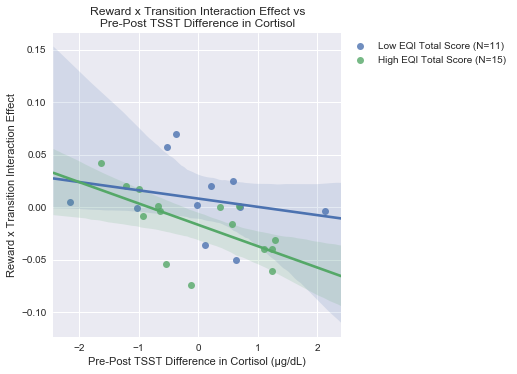

In [8]:
#Edit These
SAVE = False
var1 = diftrierlistz
var2 = modelbasedbetascortlist
groupvar = scorelist
MEANSPLIT = True
var1label = "Pre-Post TSST Difference in Cortisol (µg/dL)"
var2label = "Reward x Transition Interaction Effect"
highgrouplabel = "High EQI Total Score"
lowgrouplabel = "Low EQI Total Score"
title = "Reward x Transition Interaction Effect vs\nPre-Post TSST Difference in Cortisol"
savename = "Analyses\\Markov\\ModelBased-StressReactivity-MoodSplit.pdf"

#--------------------------------------------
table = pd.DataFrame(
    {var1label: var1,
    var2label: var2,
    'z_raw': groupvar,
    'z_group': groupvar
    })

grouplist = []

for i, x in enumerate(table.z_raw):
    if MEANSPLIT == True:
        if x > statistics.mean(groupvar):
            grouplist.append(highgrouplabel)
        else:
            grouplist.append(lowgrouplabel)
    else:
        grouplist.append(groupvar[i])

for x in list(unique_everseen(grouplist)):
    grouplist = [w.replace(x, x + ' (N=%s)' % grouplist.count(x)) for w in grouplist]
table['z_group'] = grouplist

seaborn.set(rc={'figure.figsize':(300,300)})
#seaborn.reset_orig()

lm = seaborn.lmplot(x=var1label, y=var2label, hue = 'z_group', data=table, legend=False)
ax = mp.pyplot.gca()
ax.set_title(title)
mp.pyplot.legend(bbox_to_anchor=(1, 1), loc=2)

for x in list(unique_everseen(grouplist)):
    print("%s" % x + " Group: r = %s, p = %s" % (pearsonr(table[var1label][table['z_group'] == x],table[var2label][table['z_group'] == x])))
if MEANSPLIT == True:
    print("Mean of Grouping Variable: %.4f" % statistics.mean(groupvar))
if SAVE == True:
    lm.savefig(root+savename, bbox_inches='tight')

# Generate Repeated Measures Plots (Individual)

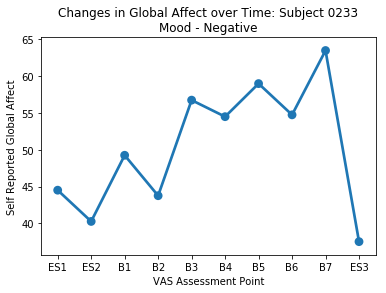

In [50]:
for i,x in enumerate(cortsubslist):
    #Edit These
    VASPLOT = True
    CORTPLOT = False
    SAVE = False
    subcharted = cortsubslist[i]
    mood = moodlist[i]
    var = vasglobalaffectcortlist[i]
    varlabel = "Self Reported Global Affect"
    title = "Changes in Global Affect over Time"
    savename = "Analyses\\VAS\\GlobalAffect-Individual\\VASGlobalAffect-%04d-%sC.pdf" % (subcharted,mood)

    #--------------------------------------------
    mp.pyplot.clf()
    pointlabel = "y"
    if VASPLOT == True:
        pointlabel = "VAS Assessment Point"
    table = pd.DataFrame(
        {varlabel: var,
         pointlabel: var
        })
    table[pointlabel] = table.index + 1
    if VASPLOT == True:
        table[pointlabel] = ['ES1','ES2','B1','B2','B3','B4','B5','B6','B7','ES3']
    if CORTPLOT == True:
        table[pointlabel] = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',]

    lm = seaborn.pointplot(x=pointlabel, y=varlabel, data=table, ci=80)
    if VASPLOT == True:
        lm.set_title("%s: Subject %04d\nMood - %s" % (title,subcharted,mood))
    else:
        lm.set_title("%s: Subject %04d" % (title,subcharted))
    if SAVE == True:
        mp.pyplot.savefig(root+savename)

# Generate Repeated Measures Plots (All + Grouped)



Mixed Linear Model Output for Positive (N=19)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: VASChange
No. Observations: 190     Method:             REML     
No. Groups:       19      Scale:              97.6635  
Min. group size:  10      Likelihood:         -728.6191
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    73.329    3.171 23.126 0.000 67.114 79.544
Time         -0.011    0.250 -0.046 0.963 -0.501  0.478
Group Var   145.450    5.506                           



Mixed Linear Model Output for Negative (N=19)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: VASChange
No. Observations: 190     Method:             REML     
No. Groups:       19   

<Figure size 432x288 with 0 Axes>

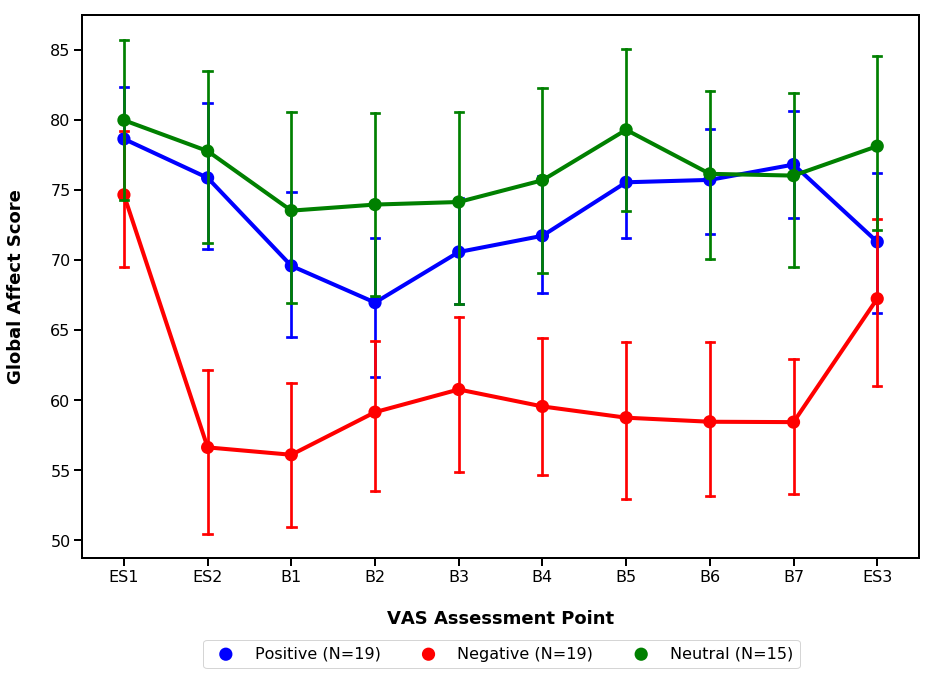

In [59]:
#Edit These
VASPLOT = True
CORTPLOT = False
SAVE = False
var = vasglobalaffectlist
varlabel = "Global Affect Score"
pointlabel = "VAS Assessment Point"
title = ""
titlefont = {'weight':'bold','size':18,}
xlabelfont = {'weight':'bold','size':18,}
ylabelfont = {'weight':'bold','size':18,}
figureparams = {'size':(15,10),'labelpad':25,'scale':1.5,'capsize':.1,'legendloc':(.145, -.15),}
savename = "Analyses\\VAS\\VASGlobalAffect-All-NEW-SE.png"

#--------------------------------------------
mp.pyplot.clf()
table = pd.DataFrame(
    {varlabel: [item for sublist in var for item in sublist],
     pointlabel: var[0]*len(var)
    })
fig, lm = mp.pyplot.subplots(figsize=figureparams['size'])
if VASPLOT == True:
    table['SubID'] = [item for item, count in zip(v2subslist, [len(var[0])]*len(var)) for i in range(count)]
    nmoodlist = moodlist
    for x in list(unique_everseen(nmoodlist)):
        nmoodlist = [w.replace(x, x + ' (N=%s)' % nmoodlist.count(x)) for w in nmoodlist]
    table[pointlabel] = ['ES1','ES2','B1','B2','B3','B4','B5','B6','B7','ES3']*len(var)
    table['Mood'] = [item for item, count in zip(nmoodlist, [len(var[0])]*len(var)) for i in range(count)]
    lm = seaborn.pointplot(x=pointlabel, y=varlabel, data=table, hue="Mood", palette=('b', 'r', 'g'), ci=80, scale=figureparams['scale'], capsize=figureparams['capsize'])
    lgd = lm.legend(bbox_to_anchor=figureparams['legendloc'], loc=2, borderaxespad=0., ncol=3, fontsize=16)
if CORTPLOT == True:
    table['SubID'] = [item for item, count in zip(list(cortsubslist), [len(var[0])]*len(var)) for i in range(count)]
    table[pointlabel] = ['12:45','13:25','13:35','14:10','15:05','15:15','15:50','16:40','17:10','17:35', '18:05']*len(var)
    lm = seaborn.pointplot(x=pointlabel, y=varlabel, data=table, color='black', ci=80, scale=figureparams['scale'], capsize=figureparams['capsize'])
    for x in [1.5, 4.5, 7.5, 9.5]:
        mp.pyplot.plot([x, x], [.35, .15], linewidth=2.5, color='b' if x==9.5 else 'r', linestyle='dotted')
for axis in ['top','bottom','left','right']:
    lm.spines[axis].set_linewidth(2)
lm.set_title(title, titlefont, loc='left')
lm.set_ylabel(varlabel, ylabelfont, labelpad=figureparams['labelpad'])
lm.set_xlabel(pointlabel, xlabelfont, labelpad=figureparams['labelpad'])
lm.tick_params(labelsize=16, size=8, direction='out', width=2)
if SAVE == True:
    fig.savefig(root+savename, bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=False)
if VASPLOT == True:    
    table[pointlabel] = [1,2,3,4,5,6,7,8,9,10]*len(var)
if CORTPLOT == True:
    table[pointlabel] = [1,2,3,4,5,6,7,8,9,10,11]*len(var)
table = table.rename(index=str, columns={varlabel: "VASChange", pointlabel: "Time"})
table = table[np.isfinite(table['VASChange'])]
table.to_csv("C:\\Users\\localadmin\\R Scripts\\R_repeatedm_linearmixed_dataset.csv", sep=',', index=False)
if VASPLOT == True:
    for x in list(unique_everseen(nmoodlist)):
        print("\n\nMixed Linear Model Output for %s\n" % x)
        md = smf.mixedlm("VASChange ~ Time + Mood", data=table[table['Mood']==x], groups=table[table['Mood']==x]["SubID"])
        mdf = md.fit()
        print(mdf.summary())

In [71]:
predictor = diftrierlist
mediator = eqirtlist
outcome = msceitmanagebranchlist
var1label = 'x'
var2label = 'y'
var3label = 'z'

table = pd.DataFrame(
    {var1label: predictor,
    var2label: mediator,
    var3label: outcome
    })

table.to_csv("C:\\Users\\localadmin\\R Scripts\\R_causalmediation_dataset.csv", sep=',', index=False)

r = 0.02877528289984539, p = 0.8890249322970446


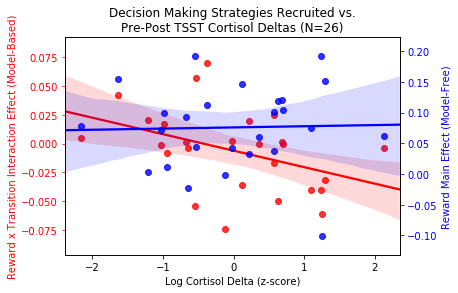

In [54]:
#Edit These
SAVE = False
var1 = diftrierlistz
var2 = modelbasedbetascortlist
var3 = modelfreebetascortlist
var1label = "Log Cortisol Delta (z-score)"
var2label = "Reward x Transition Interaction Effect (Model-Based)"
var3label = "Reward Main Effect (Model-Free)"
title = "Decision Making Strategies Recruited vs.\nPre-Post TSST Cortisol Deltas (N=%s)" % len(var1)
savename = "Analyses\\Markov\\DecisionStrat-StressReactivityLog.pdf"

#--------------------------------------------
table = pd.DataFrame(
    {var1label: var1,
    var2label: var2,
    var3label: var3
    })
for x in table.columns:
    table = table[np.isfinite(table[x])]
    
fig, ax = mp.pyplot.subplots()
ax2 = ax.twinx()
ax.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('b')
ax.tick_params(axis='y', colors='r')
ax2.tick_params(axis='y', colors='b')
lm = seaborn.regplot(x=var1label, y=var2label, color='r', data=table, ax=ax)
lm = seaborn.regplot(x=var1label, y=var3label, color='b', data=table, ax=ax2)
ax = mp.pyplot.gca()
ax.set_title(title)
#ax.set_title("%s\nr=%.4f, p=%.4f" % (title,pearsonr(table[var1label],table[var2label])[0],pearsonr(table[var1label],table[var2label])[1]))
print("r = %s, p = %s" % pearsonr(table[var1label],table[var3label]))
if SAVE == True:
    fig.savefig(root+savename, bbox_inches='tight')